In [46]:
from pynq import DefaultIP
from pynq import Overlay

class AxisSwitch(DefaultIP):
    
    CTRL_OFFSET = 0x00
    CFG_OFFSET  = 0x40
    CFG_GATE_MASK = 0x02
    CFG_DISABLE_MASK = 0x80000000
    
    def __init__(self, description):
        super().__init__(description=description)
        self.num_mi = int(description['parameters']['NUM_MI'])
        self.num_si = int(description['parameters']['NUM_SI'])
        self.disable_all()
        
    bindto = ['xilinx.com:ip:axis_switch:1.1']

    def start_cfg(self):
        self.write(AxisSwitch.CTRL_OFFSET,
          self.read(AxisSwitch.CTRL_OFFSET) &
          (~AxisSwitch.CFG_GATE_MASK)
        )
    
    def stop_cfg(self):
        self.write(AxisSwitch.CTRL_OFFSET,
          self.read(AxisSwitch.CTRL_OFFSET) |
          AxisSwitch.CFG_GATE_MASK
        )
    
    def route_pair(self, master, slave):
        self.write(AxisSwitch.CFG_OFFSET+4*master, slave)
    
    def disable_all(self):
        for i in range(self.num_mi):
            self.disable_master(i)
    
    def disable_master(self, master):
        self.write(AxisSwitch.CFG_OFFSET+4*master, AxisSwitch.CFG_DISABLE_MASK)
        

from enum import Enum

class XbarSource(Enum):
    line_in = 0
    dma     = 1
class XbarEffect(Enum):
    passthrough = 0
    low_pass_filter = 1
class XbarSink(Enum):
    headphone = 0
    dma = 1
    
class AudioLabOverlay(Overlay):
    
    def __init__(self, bitfile, **kwargs):
        super().__init__(bitfile, **kwargs)
        self.x_source = self.axis_switch_source
        self.x_sink = self.axis_switch_sink
        
    def route(self, source, effect, sink):    
        self.x_source.start_cfg()
        self.x_sink.start_cfg()
        
        self.x_source.disable_all()
        self.x_sink.disable_all()
        
        self.x_source.route_pair(effect.value,source.value)
        self.x_sink.route_pair(sink.value,effect.value)
        
        self.x_source.stop_cfg()
        self.x_sink.stop_cfg()

In [59]:
ol = AudioLabOverlay('bitstreams/se/audio_lab.bit')

Install amaork's i2c library. `pip3 install git+https://github.com/amaork/libi2c.git`

TODO install this as a dependency via setup.py

In [42]:
from audio_lab_pynq.AudioCodec import ADAU1761

a = ADAU1761()

In [43]:
a.config_pll()
a.config_codec()

Things to fix up about this driver:
  
  * Add safety checks [a la C driver](https://github.com/Xilinx/embeddedsw/blob/master/XilinxProcessorIPLib/drivers/axis_switch/src/xaxis_switch_hw.h)
  * Think about better interface / language to control the routing

In [94]:
ol.route(XbarSource.line_in, XbarEffect.passthrough, XbarSink.headphone)

In [14]:
print(bin(ol.x_source.read(0x40)))
print(bin(ol.x_sink.read(0x40)))

0b0
0b0


The DMA stuff below here is a "work in progress"

i.e. ...Don't bother

In [54]:
from pynq import Xlnk
import numpy as np
xlnk = Xlnk()

# Input array for DMA use
in_dma_array  = xlnk.cma_array(shape=(48000, 2), dtype=np.int32)
for i in range(100):
    in_dma_array[i,:]=i

out_dma_array = xlnk.cma_array(shape=(48000, 2), dtype=np.int32)

In [93]:
ol.axi_dma_0.sendchannel.transfer(in_dma_array)
ol.axi_dma_0.sendchannel.wait()

In [55]:
ol.axi_dma_0.recvchannel.transfer(out_dma_array)
ol.axi_dma_0.recvchannel.wait()

KeyboardInterrupt: 

Problem here with no TLAST? Look at docs.

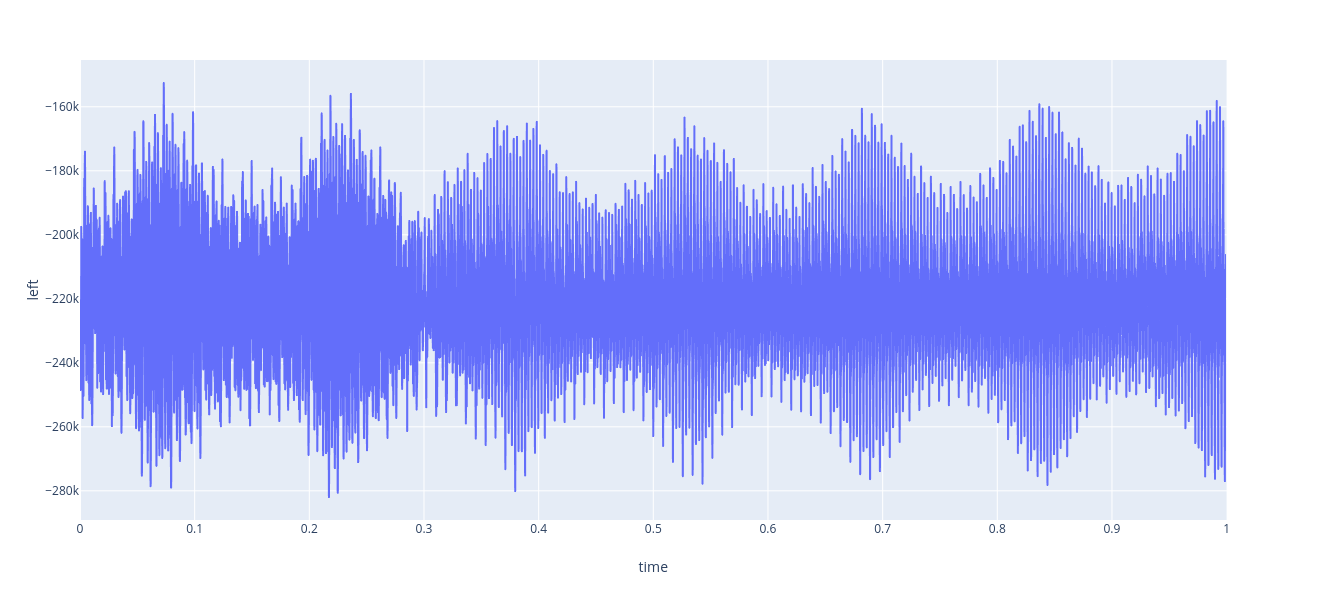

In [36]:
import plotly.express as px
import pandas as pd

dataset = pd.DataFrame({'time': np.array(range(48000))/48000,'left': out_dma_array[:, 0], 'right': out_dma_array[:, 1]})

fig = px.line(dataset, x="time", y="left")
fig.show()

Also think about how we need backpressure from the audio_top ip to make sure any DMA generated buffers get played out at the correct speeds! (Maybe something for a clash rewrite?)